In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab            # The functions in this package can add the fitting curve of the random variable distribution
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import norm
from scipy.stats import bartlett

#from scipy.cluster.hierarchy import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from functions import *
import math 


# Construisez votre échantillon contenant l'ensemble des pays disponibles, chacun caractérisé par ces variables :

   # - différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage ;
   # - proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays ;
  

# Différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage ;

Définition : On considère une valeur X qui subit une évolution pour arriver à une
valeur Y.
Le taux d'évolution est égal à : t = (Y − X)/X .

In [2]:
population = pd.read_csv("pop_2003_2013_2005_2015.csv", index_col = 0)
population['Valeur'] = population['Valeur'] * 1000
population

#Différence entre les populations de 2003 et de 2013
pop = pd.pivot_table(population, values='Valeur', index=['Zone'], 
                     columns='Année', aggfunc=sum).reset_index()
pop['percent_pop'] = (((pop[2013] - pop[2003])/(pop[2003]))*100).round(2)
pop = pop[['Zone', 'percent_pop']]
pop

Année,Zone,percent_pop
0,Afghanistan,36.27
1,Afrique du Sud,14.91
2,Albanie,-6.87
3,Algérie,18.21
4,Allemagne,-0.54
...,...,...
234,Îles Salomon,27.81
235,Îles Turques-et-Caïques,38.86
236,Îles Vierges américaines,-2.82
237,Îles Vierges britanniques,33.11


# Proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays ;
# - disponibilité alimentaire en protéines par habitant ;
# - disponibilité alimentaire en calories par habitant.



In [3]:
dispo_alim_2003_2013 = pd.read_csv("dispo_alim_2003_2013.csv", index_col = 0)
dispo_alim_2003_2013 = pd.pivot_table(dispo_alim_2003_2013, values='Valeur', index=['Pays'], columns=['Élément'], aggfunc=np.sum).reset_index()
dispo_alim_2003_2013 = dispo_alim_2003_2013.rename(columns={'Pays':'Zone', 'Disponibilité alimentaire (Kcal/personne/jour)': 'kcal_jr', 'Disponibilité de protéines en quantité (g/personne/jour)' : 'proteine_jr'})
dispo_alim_2003_2013 = dispo_alim_2003_2013[['Zone','kcal_jr', 'proteine_jr']]
dispo_alim_2003_2013

Élément,Zone,kcal_jr,proteine_jr
0,Afghanistan,4163.0,94.69
1,Afrique du Sud,6807.0,107.45
2,Albanie,5169.0,106.87
3,Algérie,6958.0,135.06
4,Allemagne,6744.0,86.10
...,...,...,...
173,Émirats arabes unis,7801.0,139.73
174,Équateur,5182.0,69.52
175,États-Unis d'Amérique,7746.0,92.62
176,Éthiopie,4525.0,106.57


In [4]:
animaux = pd.read_csv("dispo_alim_anim_2003_2013.csv", index_col = 0)
animaux = pd.pivot_table(animaux, values='Valeur', index=['Zone'], columns=['Élément'], aggfunc=np.sum).reset_index()

dispo_anim = animaux[["Zone","Disponibilité alimentaire (Kcal/personne/jour)", 
                      "Disponibilité de protéines en quantité (g/personne/jour)"]]

dispo_anim = dispo_anim.rename(columns={'Disponibilité alimentaire (Kcal/personne/jour)': 'kcal_jr_anim',
                                        'Disponibilité de protéines en quantité (g/personne/jour)': 'proteine_jr_anim'})
dispo_anim

Élément,Zone,kcal_jr_anim,proteine_jr_anim
0,Afghanistan,625.0,33.80
1,Afrique du Sud,1015.0,71.26
2,Albanie,2814.0,161.21
3,Algérie,1012.0,62.25
4,Allemagne,2648.0,156.87
...,...,...,...
173,Émirats arabes unis,1745.0,123.67
174,Équateur,1550.0,89.49
175,États-Unis d'Amérique,2729.0,184.24
176,Éthiopie,376.0,21.78


In [5]:
df = dispo_alim_2003_2013.merge(dispo_anim, on='Zone', how='left').merge(pop, on ='Zone', how='left')
df['ratio_proteine'] = (df['proteine_jr_anim']/df['proteine_jr']).round(2)
data = df[["Zone","kcal_jr","proteine_jr","percent_pop", "ratio_proteine"]]
data = data[data['Zone'] != "Chine"]
data

,Zone,kcal_jr,proteine_jr,percent_pop,ratio_proteine
0,Afghanistan,4163.0,94.69,36.27,0.36
1,Afrique du Sud,6807.0,107.45,14.91,0.66
2,Albanie,5169.0,106.87,-6.87,1.51
3,Algérie,6958.0,135.06,18.21,0.46
4,Allemagne,6744.0,86.10,-0.54,1.82
...,...,...,...,...,...
173,Émirats arabes unis,7801.0,139.73,147.79,0.89
174,Équateur,5182.0,69.52,17.49,1.29
175,États-Unis d'Amérique,7746.0,92.62,9.17,1.99
176,Éthiopie,4525.0,106.57,32.17,0.20


In [6]:
data.isnull().sum()

Zone              0
kcal_jr           0
proteine_jr       0
percent_pop       5
ratio_proteine    4
dtype: int64

In [7]:
# Imputation par la moyenne

In [8]:
ratio_mean = df["ratio_proteine"].mean()
percent_pop_mean = df["percent_pop"].mean()

data['ratio_proteine'].fillna(ratio_mean, inplace=True)
data['percent_pop'].fillna(percent_pop_mean, inplace=True)

In [9]:
data.isnull().sum()

Zone              0
kcal_jr           0
proteine_jr       0
percent_pop       0
ratio_proteine    0
dtype: int64

# Construisez un dendrogramme contenant l'ensemble des pays étudiés.

In [10]:
# préparation des données pour le clustering
data.set_index('Zone', inplace=True)
X1 = data.values

data

,kcal_jr,proteine_jr,percent_pop,ratio_proteine
Zone,,,,
Afghanistan,4163.0,94.69,36.27,0.36
Afrique du Sud,6807.0,107.45,14.91,0.66
Albanie,5169.0,106.87,-6.87,1.51
Algérie,6958.0,135.06,18.21,0.46
Allemagne,6744.0,86.10,-0.54,1.82
...,...,...,...,...
Émirats arabes unis,7801.0,139.73,147.79,0.89
Équateur,5182.0,69.52,17.49,1.29
États-Unis d'Amérique,7746.0,92.62,9.17,1.99


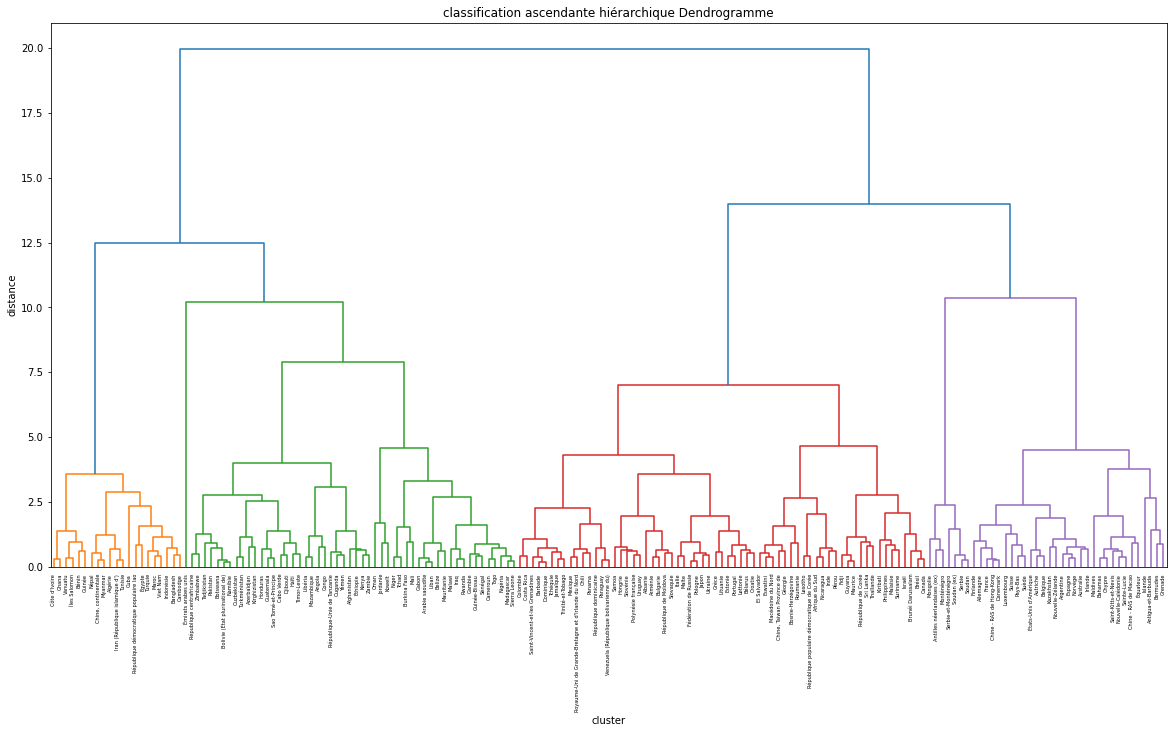

In [11]:
# conversion des nombres entiers en nombres décimaux (float) : necessaire pour le StandardScaler
X1 = X1.astype(np.float64)
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X1)
X1_scaled = std_scale.transform(X1)

# Clustering hiérarchique
Z1 = linkage(X1_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(20,10))
plt.title('classification ascendante hiérarchique Dendrogramme')
plt.ylabel('distance')
plt.xlabel('cluster')
 #treshhold justif

sch.dendrogram(Z1, labels = names, color_threshold=12 )
# color_threshold permet de couper le dendrogramme en groupe à partir de la distance sélectionnée
#Affichage latéral gauche du dendrogramme avec l'option orientation
plt.show()

# Interprétation du dendrogramme
 Ce dendrogramme a été créé avec une subdivision finale de 5 groupes,
 ce qui se produit à un niveau de similarité de 8.

In [12]:
#découpage à la hauteur t =12, on aura 4 groupes
groupes= fcluster(Z1,t=12,criterion='distance')
groupes

array([2, 3, 3, 1, 4, 2, 4, 4, 2, 4, 3, 4, 4, 2, 4, 1, 3, 4, 2, 4, 2, 3,
       2, 3, 3, 3, 2, 3, 1, 2, 1, 2, 3, 3, 4, 4, 3, 1, 4, 3, 2, 3, 3, 1,
       1, 4, 2, 3, 3, 4, 3, 3, 3, 4, 4, 3, 2, 2, 1, 4, 3, 2, 1, 2, 3, 3,
       2, 2, 3, 3, 1, 1, 2, 4, 4, 3, 3, 3, 3, 2, 4, 2, 2, 3, 2, 3, 3, 2,
       2, 3, 4, 3, 2, 3, 2, 4, 2, 3, 1, 3, 2, 3, 4, 4, 2, 1, 2, 3, 2, 2,
       4, 4, 4, 1, 2, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3,
       3, 1, 3, 2, 4, 3, 4, 3, 2, 4, 4, 2, 3, 3, 4, 4, 3, 4, 3, 4, 2, 2,
       2, 3, 3, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 1, 2, 2, 2, 1, 2, 4, 4, 2,
       1], dtype=int32)

In [13]:
data.index

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Antilles néerlandaises (ex)',
       'Arabie saoudite', 'Argentine',
       ...
       'Viet Nam', 'Yémen', 'Zambie', 'Zimbabwe', 'Égypte',
       'Émirats arabes unis', 'Équateur', 'États-Unis d'Amérique', 'Éthiopie',
       'Îles Salomon'],
      dtype='object', name='Zone', length=177)

In [14]:
data.values

array([[ 4.16300000e+03,  9.46900000e+01,  3.62700000e+01,
         3.60000000e-01],
       [ 6.80700000e+03,  1.07450000e+02,  1.49100000e+01,
         6.60000000e-01],
       [ 5.16900000e+03,  1.06870000e+02, -6.87000000e+00,
         1.51000000e+00],
       [ 6.95800000e+03,  1.35060000e+02,  1.82100000e+01,
         4.60000000e-01],
       [ 6.74400000e+03,  8.61000000e+01, -5.40000000e-01,
         1.82000000e+00],
       [ 6.08400000e+03,  8.66300000e+01,  4.35600000e+01,
         3.90000000e-01],
       [ 4.43900000e+03,  5.41100000e+01,  1.54000000e+01,
         2.38000000e+00],
       [ 3.50300000e+03,  4.43400000e+01,  2.24200000e+01,
         1.75000000e+00],
       [ 7.29400000e+03,  1.16350000e+02,  3.38200000e+01,
         7.30000000e-01],
       [ 6.48300000e+03,  8.08000000e+01,  1.07900000e+01,
         1.86000000e+00],
       [ 5.57000000e+03,  9.73300000e+01, -3.99000000e+00,
         1.03000000e+00],
       [ 6.30900000e+03,  8.46100000e+01,  1.85000000e+01,
      

In [15]:
groupes = pd.DataFrame(groupes, columns=['cluster'], index=data.index)
groupes

,cluster
Zone,
Afghanistan,2
Afrique du Sud,3
Albanie,3
Algérie,1
Allemagne,4
...,...
Émirats arabes unis,2
Équateur,4
États-Unis d'Amérique,4


In [16]:
# Concaténer selon les colonnes (axis=1) ou l'index(axis=0)
clusters = pd.concat([data, groupes], axis=1).reset_index()
clusters1 = clusters.copy()
clusters1

,Zone,kcal_jr,proteine_jr,percent_pop,ratio_proteine,cluster
0,Afghanistan,4163.0,94.69,36.27,0.36,2
1,Afrique du Sud,6807.0,107.45,14.91,0.66,3
2,Albanie,5169.0,106.87,-6.87,1.51,3
3,Algérie,6958.0,135.06,18.21,0.46,1
4,Allemagne,6744.0,86.10,-0.54,1.82,4
...,...,...,...,...,...,...
172,Émirats arabes unis,7801.0,139.73,147.79,0.89,2
173,Équateur,5182.0,69.52,17.49,1.29,4
174,États-Unis d'Amérique,7746.0,92.62,9.17,1.99,4
175,Éthiopie,4525.0,106.57,32.17,0.20,2


# Caractérisez chacun de ces groupes selon les variables cités précédemment, 
# et facultativement selon d'autres variables que vous jugerez pertinentes (ex : le PIB par habitant). 
# Vous pouvez le faire en calculant la position des centroïdes de chacun des groupes, puis en les commentant et en les critiquant au vu de vos objectifs.


In [17]:
clusters_kcal = clusters.groupby(by='cluster').describe()['kcal_jr']
clusters_proteine = clusters.groupby(by='cluster').describe()['proteine_jr']
clusters_ratio = clusters.groupby(by='cluster').describe()['ratio_proteine']
clusters_percent = clusters.groupby(by='cluster').describe()['percent_pop']
clusters_ratio

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,21.0,0.313333,0.127528,0.13,0.220,0.33,0.4400,0.57
2,53.0,0.455094,0.269513,0.10,0.210,0.39,0.6900,1.11
3,65.0,1.012263,0.375485,0.16,0.750,1.02,1.2500,1.76
4,38.0,1.835789,0.419225,1.01,1.625,1.79,2.0275,3.33


In [18]:
centroids_cluster = clusters.groupby(by='cluster').mean().reset_index()
centroids_cluster

,cluster,kcal_jr,proteine_jr,percent_pop,ratio_proteine
0,1,7822.476190,145.539048,16.737143,0.313333
1,2,6054.905660,108.437547,32.278679,0.455094
2,3,6762.184615,101.771846,5.122308,1.012263
3,4,5523.710526,74.774211,12.515068,1.835789


C:\Users\dell\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


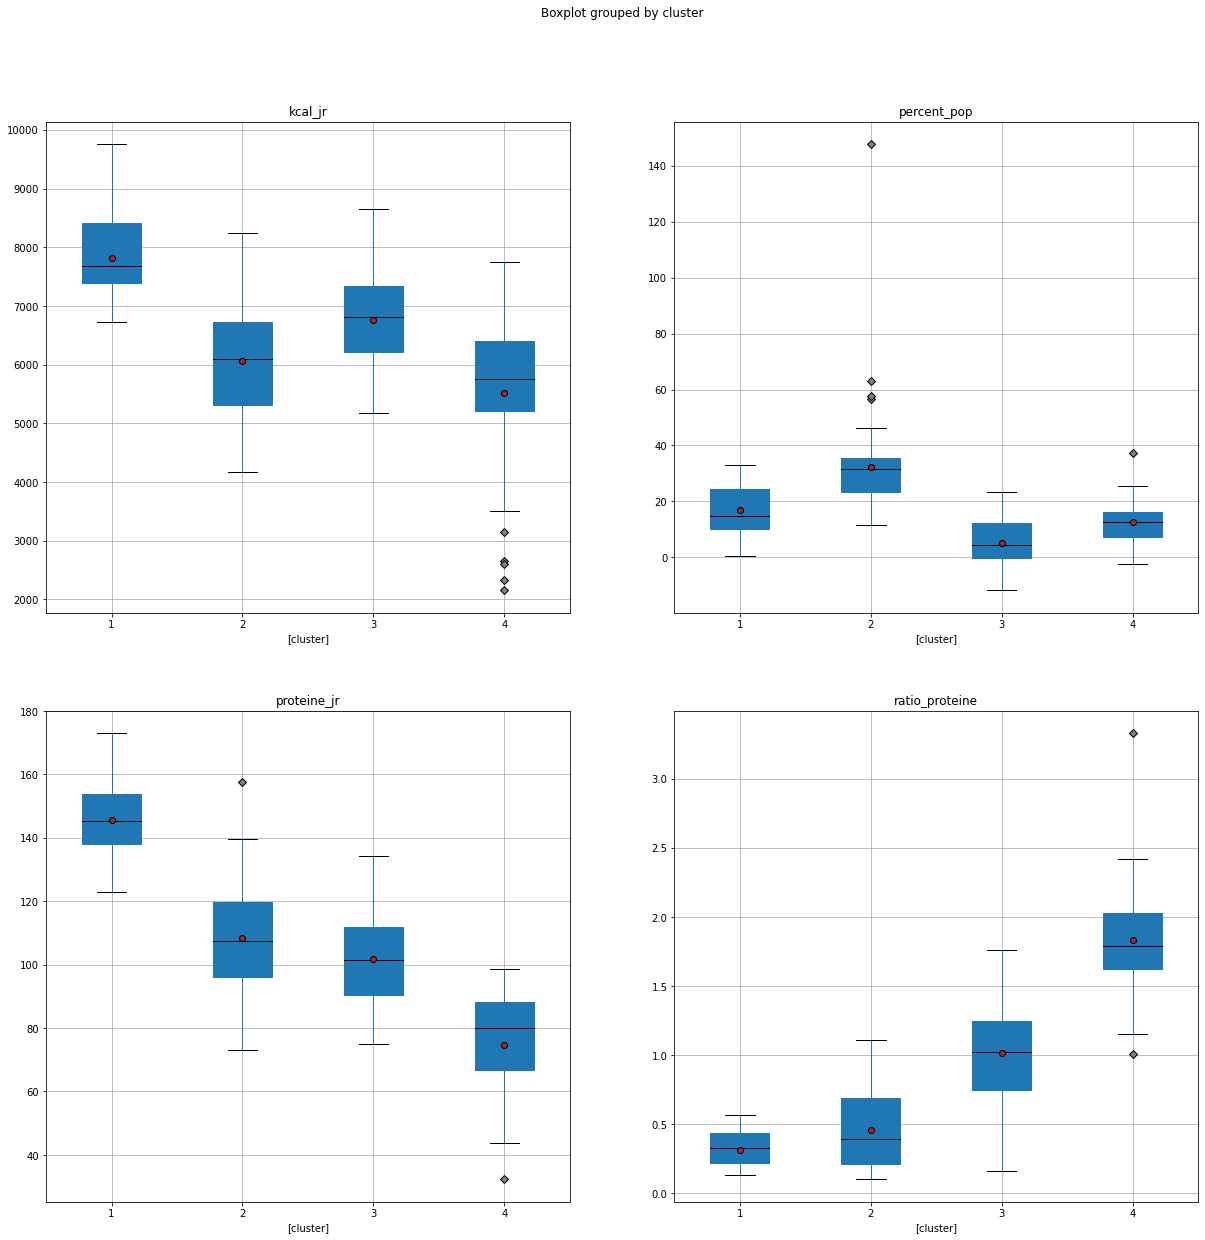

In [19]:
fig, ax_new = plt.subplots(2,2, sharey=False, figsize=(20,20))
red_diamond = dict(markerfacecolor='gray', marker='D')
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

bplot1 = clusters.boxplot(by="cluster", grid = True, showfliers=True, medianprops=medianprops, vert=True, showmeans=True, meanprops=meanprops, ax=ax_new,patch_artist=True, flierprops=red_diamond)
#plt.title("Répartition des groupes de boxplots des variables selon les clusters")
plt.show()

Text(0.5, 1.0, 'sous-groupes de clusters par kcal_jr')

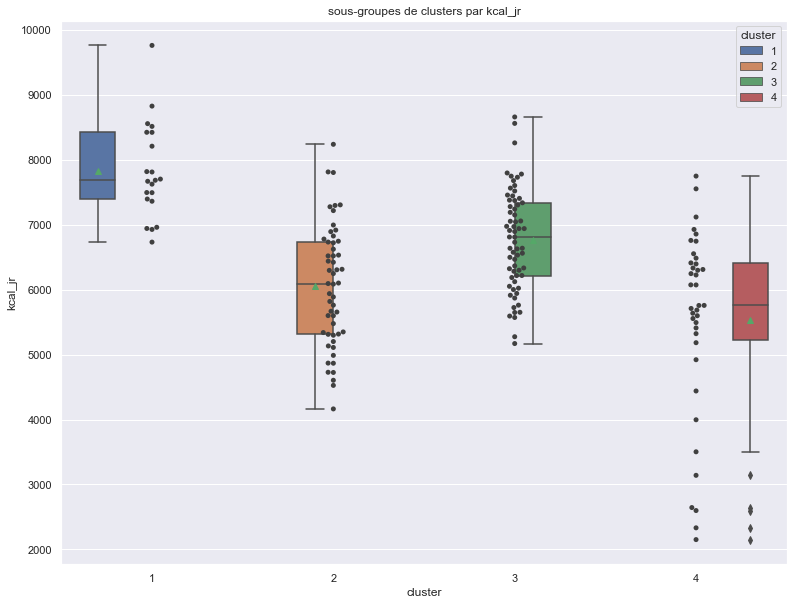

In [20]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bplt1 = sns.boxplot(x='cluster', y='kcal_jr', data=clusters, showmeans=True, hue='cluster').set_title("sous-groupes de clusters par kcal_jr")

# methode swarmplot nous permet de visualiser d'une meilleure façon la distribution des individus le long du boxplot
sns.swarmplot(x='cluster', y='kcal_jr',  data=clusters, color=".25")
bplt1

Text(0.5, 1.0, 'sous-groupes de clusters par proteine_jr')

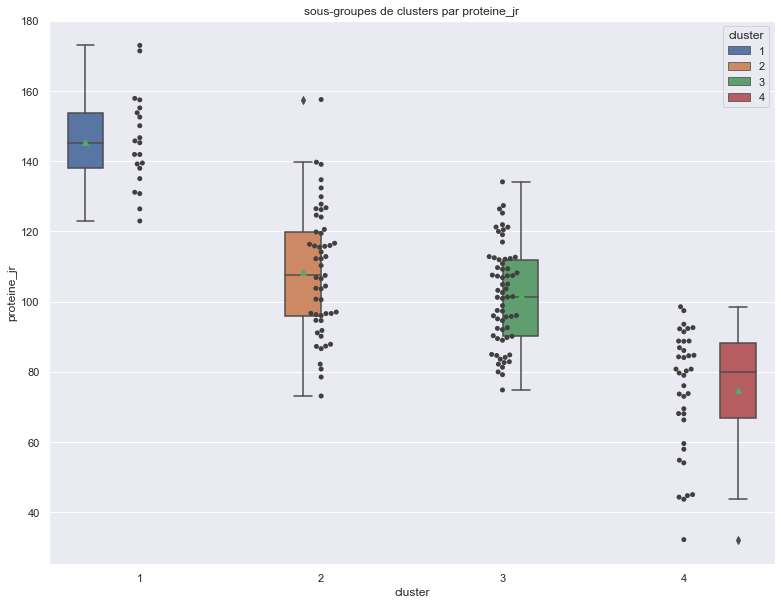

In [21]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bplt2 = sns.boxplot(x='cluster', y='proteine_jr', data=clusters, showmeans=True, hue='cluster').set_title("sous-groupes de clusters par proteine_jr")

# methode swarmplot nous permet de visualiser d'une meilleure façon la distribution des individus le long du boxplot
sns.swarmplot(x='cluster', y='proteine_jr',  data=clusters, color=".25")
bplt2

Text(0.5, 1.0, 'sous-groupes de clusters par ratio_proteine')

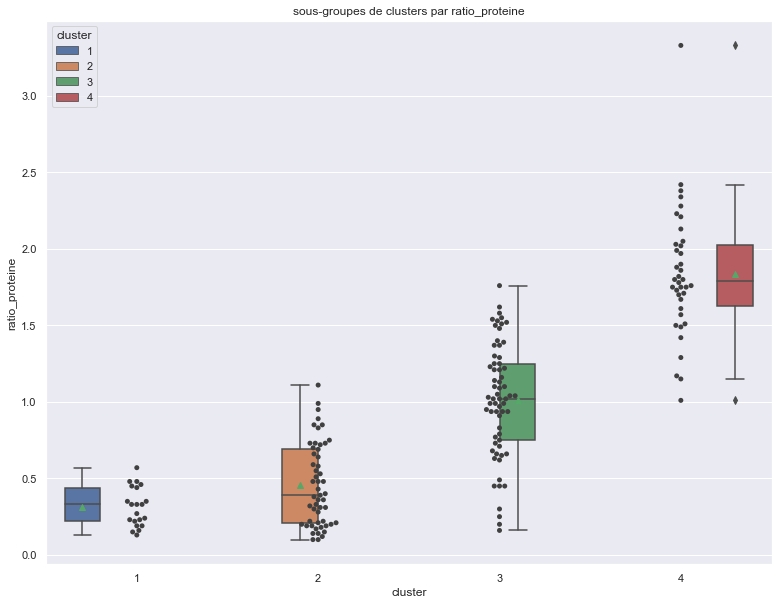

In [22]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bplt3 = sns.boxplot(x='cluster', y='ratio_proteine', data=clusters, showmeans=True, hue='cluster').set_title("sous-groupes de clusters par ratio_proteine")

# methode swarmplot nous permet de visualiser d'une meilleure façon la distribution des individus le long du boxplot
sns.swarmplot(x='cluster', y='ratio_proteine',  data=clusters, color=".25")
bplt3

Text(0.5, 1.0, 'sous-groupes de clusters par percent_pop')

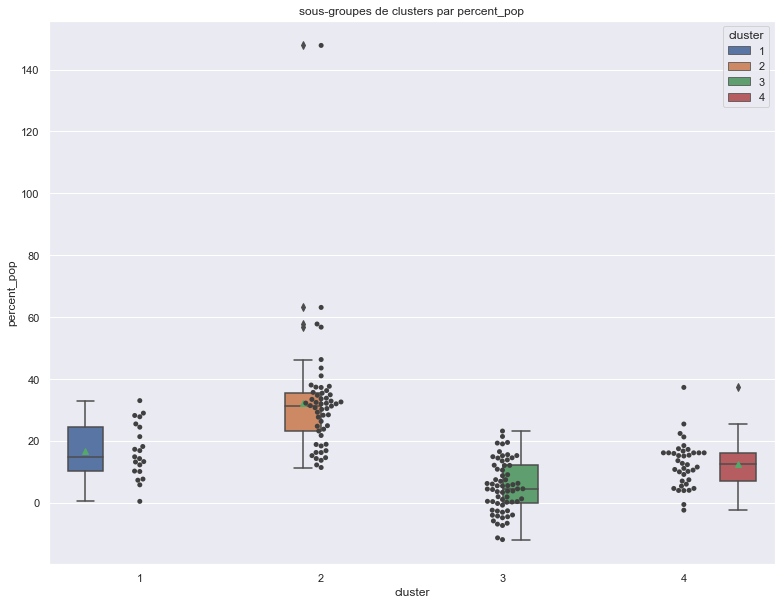

In [23]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bplt4 = sns.boxplot(x='cluster', y='percent_pop', data=clusters, showmeans=True, hue='cluster').set_title("sous-groupes de clusters par percent_pop")

# methode swarmplot nous permet de visualiser d'une meilleure façon la distribution des individus le long du boxplot
sns.swarmplot(x='cluster', y='percent_pop',  data=clusters, color=".25")
bplt4

# Les pays du cluster 1 possèdent les meilleures proportions en terme de kcal/jr/hbt.

# Par contre, en termes de de ratio de protéines d'origine animale sur la disponibilité alimentaire en proteine le cluster 4 possède le meilleur rendement. 

# Etant à la recherche du cluster le mieux adapté pour notre insertion dans le marché du poulet.

# Notre choix sera fait sur le cluster 4.


In [24]:
data = data.reset_index()
data

,Zone,kcal_jr,proteine_jr,percent_pop,ratio_proteine
0,Afghanistan,4163.0,94.69,36.27,0.36
1,Afrique du Sud,6807.0,107.45,14.91,0.66
2,Albanie,5169.0,106.87,-6.87,1.51
3,Algérie,6958.0,135.06,18.21,0.46
4,Allemagne,6744.0,86.10,-0.54,1.82
...,...,...,...,...,...
172,Émirats arabes unis,7801.0,139.73,147.79,0.89
173,Équateur,5182.0,69.52,17.49,1.29
174,États-Unis d'Amérique,7746.0,92.62,9.17,1.99
175,Éthiopie,4525.0,106.57,32.17,0.20


In [25]:
cluster_choisi = clusters[clusters.cluster==4]
cluster_choisi

,Zone,kcal_jr,proteine_jr,percent_pop,ratio_proteine,cluster
4,Allemagne,6744.0,86.10,-0.54000,1.82,4
6,Antigua-et-Barbuda,4439.0,54.11,15.40000,2.38,4
7,Antilles néerlandaises (ex),3503.0,44.34,22.42000,1.75,4
9,Argentine,6483.0,80.80,10.79000,1.86,4
11,Australie,6309.0,84.61,18.50000,2.05,4
12,Autriche,7116.0,92.28,4.65000,1.78,4
14,Bahamas,5684.0,73.03,17.26000,1.80,4
17,Belgique,7550.0,91.43,7.05000,1.71,4
19,Bermudes,4920.0,57.99,-2.36000,2.21,4
34,Chine - RAS de Hong-Kong,6297.0,86.89,5.41000,1.97,4


In [26]:
centroid_choisi = centroids_cluster[centroids_cluster.cluster==4]
centroid_choisi

,cluster,kcal_jr,proteine_jr,percent_pop,ratio_proteine
3,4,5523.710526,74.774211,12.515068,1.835789


##### Visualisez vos  partitions dans le premier plan factoriel obtenu par ACP.

# ACP sur le cluster choisi


In [27]:
# selection des colonnes du 1e clustering à prendre en compte dans l'acp'
data_acp = clusters[["kcal_jr","proteine_jr", "percent_pop", "ratio_proteine"]]
data_cor = clusters[["kcal_jr","proteine_jr", "percent_pop", "ratio_proteine"]]
#matrice des correlations
data_cor.corr()

,kcal_jr,proteine_jr,percent_pop,ratio_proteine
kcal_jr,1.000000,0.645134,0.028898,-0.243950
proteine_jr,0.645134,1.000000,0.199277,-0.635716
percent_pop,0.028898,0.199277,1.000000,-0.344443
ratio_proteine,-0.243950,-0.635716,-0.344443,1.000000


In [28]:
#theme = [clusters2.loc[sous_groupe_id, "sous_groupe"] for sous_groupe_id in data_pca.index]


In [29]:
data_acp.shape[1]

4

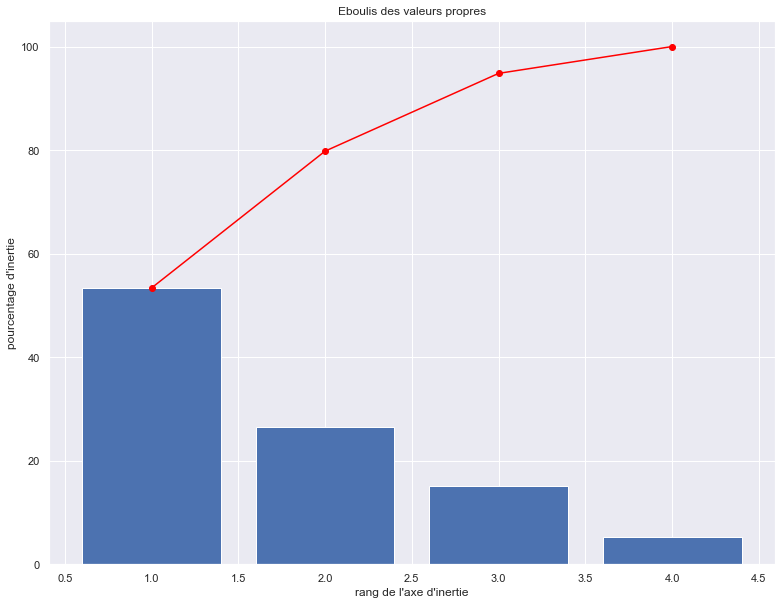

In [30]:
# choix du nombre de composantes à calculer

ensemble = [clusters.loc[cluster_id, "cluster"] for cluster_id in clusters.index]

# préparation des données pour l'ACP
X3 = data_acp.values
features = data_acp.columns
n_comp = len(features)

cluster_columns = clusters.groupby("cluster").mean()
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X3)
X3_scaled = std_scale.transform(X3)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X3_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Les 2 axes d'inertie F1 et F2 représentent 80% des données.

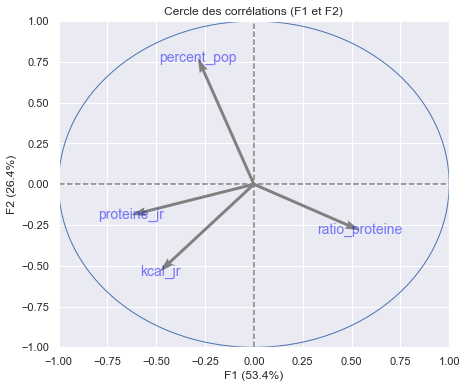

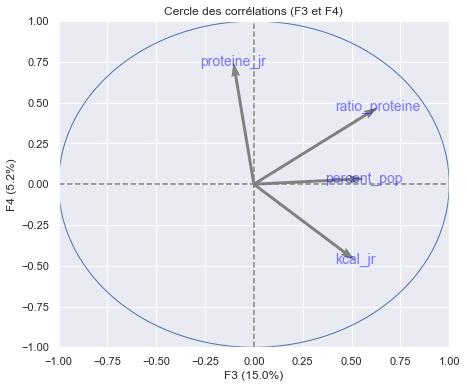

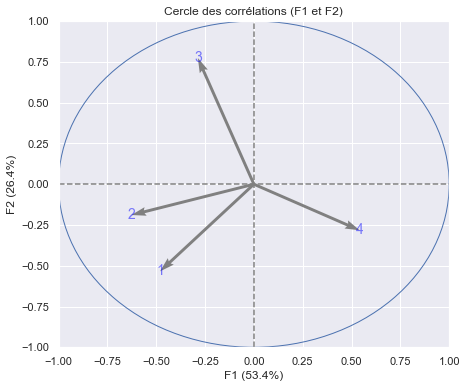

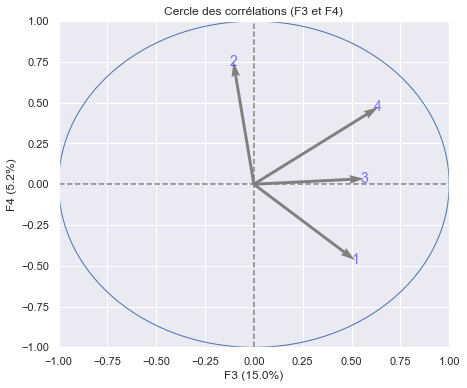

In [31]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(centroids_cluster.cluster))

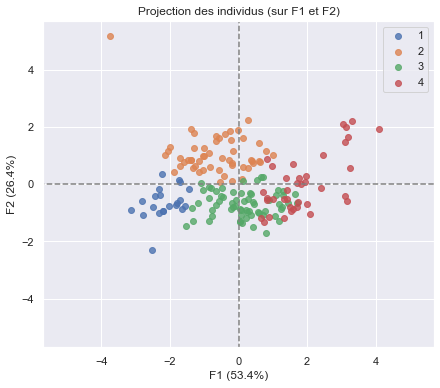

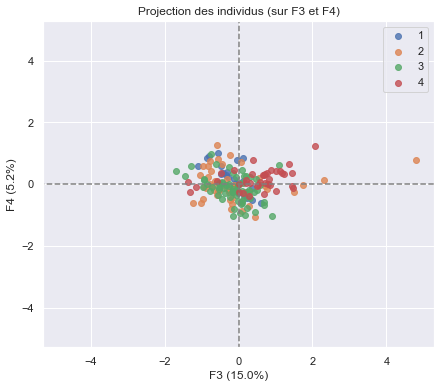

In [32]:
# Projection des individus
X3_projected = pca.transform(X3_scaled)
display_factorial_planes(X3_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = ensemble, alpha = 0.8)


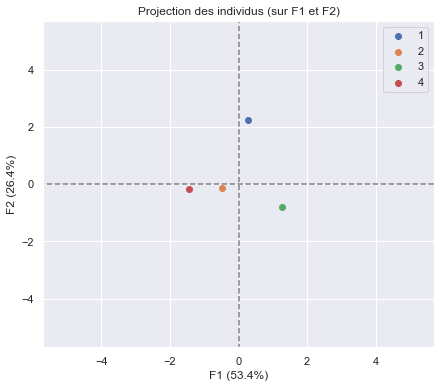

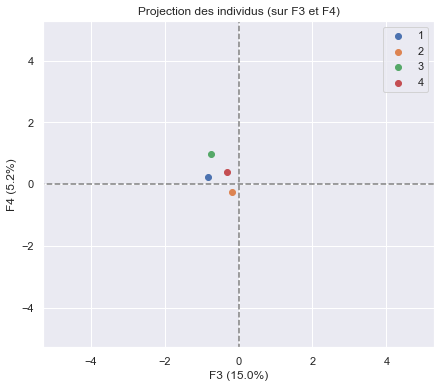

In [33]:
# Projection des individus
X3_projected = pca.transform(X3_scaled)

# Projection des clusters

display_factorial_planes(X3_projected, n_comp, pca, [(0,1),(2,3)],labels=None,alpha=1,illustrative_var=centroids_cluster.cluster)

plt.show()

In [34]:
pd.DataFrame(X3_scaled, columns=features, index=clusters.index)

,kcal_jr,proteine_jr,percent_pop,ratio_proteine
0,-1.859785,-0.334874,1.191101,-0.913582
1,0.328284,0.169349,-0.077763,-0.440473
2,-1.027259,0.146430,-1.371577,0.900002
3,0.453246,1.260383,0.118270,-0.755879
4,0.276148,-0.674315,-0.995551,1.388881
...,...,...,...,...
172,1.150879,1.444922,7.815808,-0.077757
173,-1.016501,-1.329489,0.075499,0.553055
174,1.105363,-0.416672,-0.418740,1.656976
175,-1.560208,0.134575,0.947546,-1.165907


In [35]:
n_comp_f = 2
X3_scaled = preprocessing.StandardScaler().fit_transform(data_acp.values)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp_f)
X3_projected = pca.fit_transform(X3_scaled)
pd.DataFrame(X3_projected, index=clusters.index, columns=["F"+str(i+1) for i in range(n_comp_f)])

,F1,F2
0,0.266812,2.236942
1,-0.480269,-0.143092
2,1.282800,-0.794679
3,-1.451686,-0.175090
4,1.328353,-1.183174
...,...,...
172,-3.743470,5.183172
173,1.600148,0.696368
174,0.748171,-1.304221
175,-0.238372,1.871015


In [36]:
f1 = pca.components_[0]
print(f1)

[-0.48042567 -0.6271606  -0.28688399  0.54181024]


In [37]:
X3_scaled = preprocessing.StandardScaler().fit_transform(centroids_cluster.values)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp_f)
X3_projected = pca.fit_transform(X3_scaled)
centroids_dimensions = pd.DataFrame(X3_projected, index=centroids_cluster.cluster, columns=["F"+str(i+1) for i in range(n_comp_f)] )
centroids_dimensions

,F1,F2
cluster,,
1,-2.601148,-0.655530
2,-0.670506,1.757512
3,0.546275,-1.136527
4,2.725379,0.034545


In [38]:
#Un ficher CSV contenant les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.
centroids_dimensions.to_csv('centroids_df.csv')

In [39]:
# Un fichier CSV contenant la liste des pays ainsi que (pour chacun d'entre eux) leur groupe que vous aurez déterminé après avoir découpé le dendrogramme.
clusters.to_csv('cluster_pays.csv')

In [40]:
# TESTS SUR CLUSTERS
# Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

    # 1) un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;


array([[<AxesSubplot:title={'center':'kcal_jr'}>,
        <AxesSubplot:title={'center':'proteine_jr'}>],
       [<AxesSubplot:title={'center':'percent_pop'}>,
        <AxesSubplot:title={'center':'ratio_proteine'}>],
       [<AxesSubplot:title={'center':'cluster'}>, <AxesSubplot:>]],
      dtype=object)

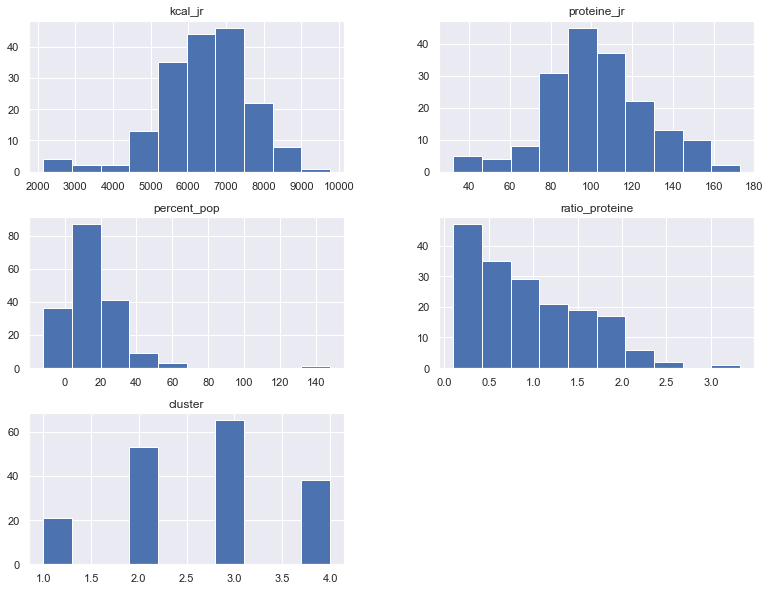

In [41]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
clusters.hist()

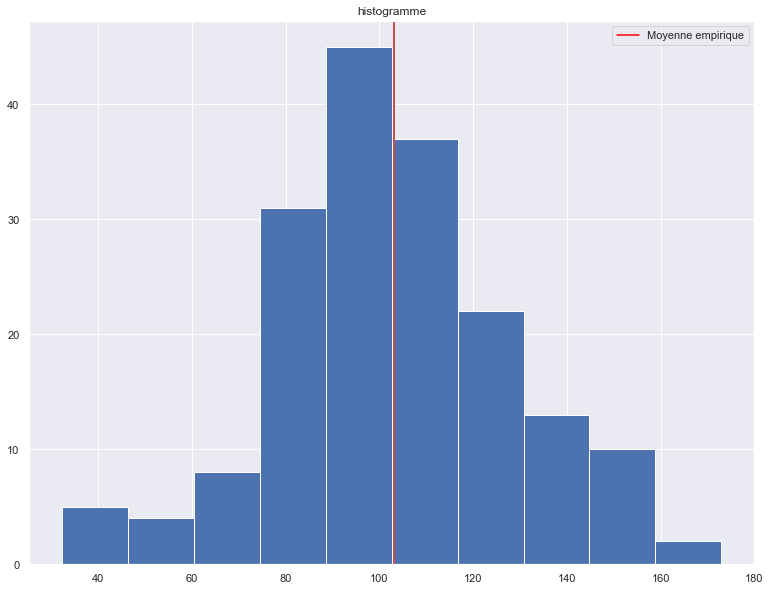

In [42]:
#  histogramme de la disponibilité alimentaire de proteines 


# moyenne de l'echantillon
xbar_prot=np.mean(clusters['proteine_jr'])
round(xbar_prot,2)

# l'ecart type de l'echantillon
sprime_prot = np.std(clusters['proteine_jr'], ddof=1)
round(sprime_prot,2)

# variance de l'echantillon
sprime2_prot = np.var(clusters['proteine_jr'], ddof=1)
round(sprime2_prot,2)

plt.hist(clusters['proteine_jr'])
plt.title("histogramme")
plt.axvline(xbar_prot, color='r', linewidth=2)
import matplotlib.lines as mlines
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])

C:\Users\dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


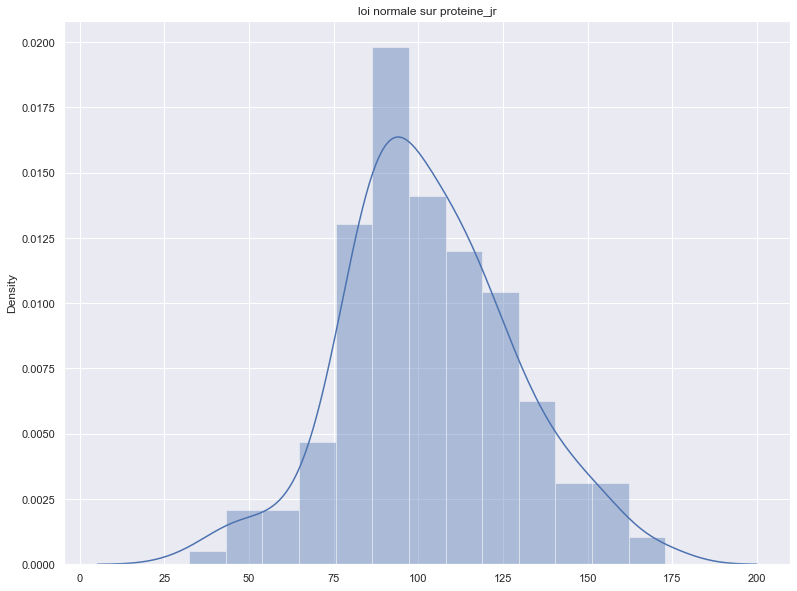

In [43]:
ax = sns.distplot(x = clusters.proteine_jr, norm_hist=True).set_title('loi normale sur proteine_jr')
#sns.histplot(clusters.proteine_jr, color="blue", label="100% Equities", kde=False, norm_hist=True, linewidth=2)


In [44]:
# import librairie pingouin
import pingouin as pg

# - Faire le test d'adéquation à une loi normale 
pg.normality(clusters, method='shapiro', alpha=0.05).round(3)

# Normality test. ‘shapiro’ (default) performs the Shapiro-Wilk test using scipy.stats.shapiro()
# and ‘normaltest’ performs the omnibus test of normality using scipy.stats.normaltest(). 
# The latter is more appropriate for large samples.



,W,pval,normal
kcal_jr,0.962,0.00,False
proteine_jr,0.988,0.16,True
percent_pop,0.814,0.00,False
ratio_proteine,0.936,0.00,False
cluster,0.876,0.00,False


In [45]:
# La pvalue vaut 0.16, la variable proteine_jr suit la loi normale pour 1 de test de 0.05

# 2) un test de comparaison de deux populations (dans le cas gaussien) : 
# choisissez 2 clusters (les plus éloignés et les plus proches)parmi ceux que vous aurez déterminé. 
# Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.


In [46]:
# Test de comparaison sur sous-groupes 1 et 4 les plus éloignés
comp2 = clusters[clusters["cluster"]==2]["proteine_jr"]
comp4 = clusters[clusters["cluster"]==4]["proteine_jr"]

In [47]:
# On teste tout d’abord l’égalité des variances
from scipy.stats import bartlett

scipy.stats.bartlett(comp2,comp4)

BartlettResult(statistic=0.037317210109214675, pvalue=0.846820641108601)

Test de students indépendant
H0: egalité des variances

H1: on n'a pas une égalité des variances

pvalue est supérieure à 0.05 alors, on accepte l'hypothèse H0.

# Car la pvalue vaut 0.84, on accepte l'égalité des variances pour un test de 0.05

In [48]:
# On teste ensuite l’égalité des moyennes:

scipy.stats.ttest_ind(comp2,comp4, equal_var=True)

Ttest_indResult(statistic=9.009873388398711, pvalue=3.5838101995130705e-14)


H0: egalité des moyennes

H1: on n'a pas une égalité des moyennes

pvalue < 0.05 de ce fait, on rejette l'hypothèse H0.


In [49]:
# Test de comparaison sur les sous-groupes les plus proches
comp3 = clusters[clusters["cluster"]==3]["proteine_jr"]

In [50]:
# On teste tout d’abord l’égalité des variances
from scipy.stats import bartlett

scipy.stats.bartlett(comp2,comp3)

BartlettResult(statistic=3.4485663071905357, pvalue=0.06330666057828578)

Test de students indépendant
H0: egalité des variances

H1: on n'a pas une égalité des variances

pvalue est supérieure à 0.05 alors, on accepte l'hypothèse H0.

# Car la pvalue vaut 0.063, on accepte l'égalité des variances pour un test de 0.05

In [51]:
# On teste ensuite l’égalité des moyennes des clusters les plus proches :

scipy.stats.ttest_ind(comp2,comp3, equal_var=True)

Ttest_indResult(statistic=2.2833969154117844, pvalue=0.024227567606660245)


H0: egalité des moyennes

H1: on n'a pas une égalité des moyennes

on rejette l'hypothèse H0 car pvalue est supérieure à 0.05 de ce fait, 

pvalue = 0.024


# Les moyennes sont significativement différentes.

# Ajout de la variable PIB au cluster choisi, pour une meilleure visibilité de la composition des clusters

In [52]:
pib = pd.read_csv("pib_2003_2013.csv", index_col = 0)
pib

,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
Code Domaine,,,,,,,,,,,,,,
MK,Indicateurs macro,2,Afghanistan,6110,Valeur US $,22008,Produit Intérieur Brut,2003,2003,millions,4729.042179,X,Sources internationales sûres,NaN
MK,Indicateurs macro,2,Afghanistan,6110,Valeur US $,22008,Produit Intérieur Brut,2013,2013,millions,19621.802455,X,Sources internationales sûres,NaN
MK,Indicateurs macro,202,Afrique du Sud,6110,Valeur US $,22008,Produit Intérieur Brut,2003,2003,millions,175255.727017,X,Sources internationales sûres,NaN
MK,Indicateurs macro,202,Afrique du Sud,6110,Valeur US $,22008,Produit Intérieur Brut,2013,2013,millions,366644.891404,X,Sources internationales sûres,NaN
MK,Indicateurs macro,3,Albanie,6110,Valeur US $,22008,Produit Intérieur Brut,2003,2003,millions,5561.459461,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK,Indicateurs macro,249,Yémen,6110,Valeur US $,22008,Produit Intérieur Brut,2013,2013,millions,34755.287255,X,Sources internationales sûres,NaN
MK,Indicateurs macro,251,Zambie,6110,Valeur US $,22008,Produit Intérieur Brut,2003,2003,millions,4901.869723,X,Sources internationales sûres,NaN
MK,Indicateurs macro,251,Zambie,6110,Valeur US $,22008,Produit Intérieur Brut,2013,2013,millions,26585.248763,X,Sources internationales sûres,NaN


In [53]:
pib[pib.Zone=="Chine"]

,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
Code Domaine,,,,,,,,,,,,,,
MK,Indicateurs macro,351,Chine,6110,Valeur US $,22008,Produit Intérieur Brut,2003,2003,millions,1.829861e+06,A,"Agrégat, peut inclure des données officielles,...",NaN
MK,Indicateurs macro,351,Chine,6110,Valeur US $,22008,Produit Intérieur Brut,2013,2013,millions,9.897719e+06,A,"Agrégat, peut inclure des données officielles,...",NaN


In [54]:
pib['Valeur'] = pib['Valeur']*1000000
pib = pd.pivot_table(pib, values='Valeur', index=['Zone'],  columns='Année', aggfunc=sum).reset_index()
pib

Année,Zone,2003,2013
0,Afghanistan,4.729042e+09,1.962180e+10
1,Afrique du Sud,1.752557e+11,3.666449e+11
2,Albanie,5.561459e+09,1.277628e+10
3,Algérie,6.786385e+10,2.097550e+11
4,Allemagne,2.496032e+12,3.732743e+12
...,...,...,...
208,Îles Cook,1.666966e+08,2.892015e+08
209,Îles Marshall,1.272481e+08,1.923057e+08
210,Îles Salomon,3.142576e+08,1.052663e+09
211,Îles Turques-et-Caïques,4.097536e+08,7.407770e+08


In [55]:
pib["pib"] = pib[2013]
pib

Année,Zone,2003,2013,pib
0,Afghanistan,4.729042e+09,1.962180e+10,1.962180e+10
1,Afrique du Sud,1.752557e+11,3.666449e+11,3.666449e+11
2,Albanie,5.561459e+09,1.277628e+10,1.277628e+10
3,Algérie,6.786385e+10,2.097550e+11,2.097550e+11
4,Allemagne,2.496032e+12,3.732743e+12,3.732743e+12
...,...,...,...,...
208,Îles Cook,1.666966e+08,2.892015e+08,2.892015e+08
209,Îles Marshall,1.272481e+08,1.923057e+08,1.923057e+08
210,Îles Salomon,3.142576e+08,1.052663e+09,1.052663e+09
211,Îles Turques-et-Caïques,4.097536e+08,7.407770e+08,7.407770e+08


In [56]:
pib = pib[["Zone", "pib"]]
pib = pib[pib["Zone"] != "Chine"]
pib

Année,Zone,pib
0,Afghanistan,1.962180e+10
1,Afrique du Sud,3.666449e+11
2,Albanie,1.277628e+10
3,Algérie,2.097550e+11
4,Allemagne,3.732743e+12
...,...,...
208,Îles Cook,2.892015e+08
209,Îles Marshall,1.923057e+08
210,Îles Salomon,1.052663e+09
211,Îles Turques-et-Caïques,7.407770e+08


In [57]:
cluster_pib = cluster_choisi.merge(pib, on="Zone", how="left")

percent_pib_mean = pib["pib"].mean()

cluster_pib["pib"].fillna(percent_pib_mean, inplace=True)
cluster_pib.isnull().sum()

Zone              0
kcal_jr           0
proteine_jr       0
percent_pop       0
ratio_proteine    0
cluster           0
pib               0
dtype: int64

In [58]:
cluster_pib.head(5)

,Zone,kcal_jr,proteine_jr,percent_pop,ratio_proteine,cluster,pib
0,Allemagne,6744.0,86.10,-0.54,1.82,4,3.732743e+12
1,Antigua-et-Barbuda,4439.0,54.11,15.40,2.38,4,1.181448e+09
2,Antilles néerlandaises (ex),3503.0,44.34,22.42,1.75,4,3.660820e+11
3,Argentine,6483.0,80.80,10.79,1.86,4,6.133160e+11
4,Australie,6309.0,84.61,18.50,2.05,4,1.543216e+12


# Construisez un dendrogramme du cluster 2

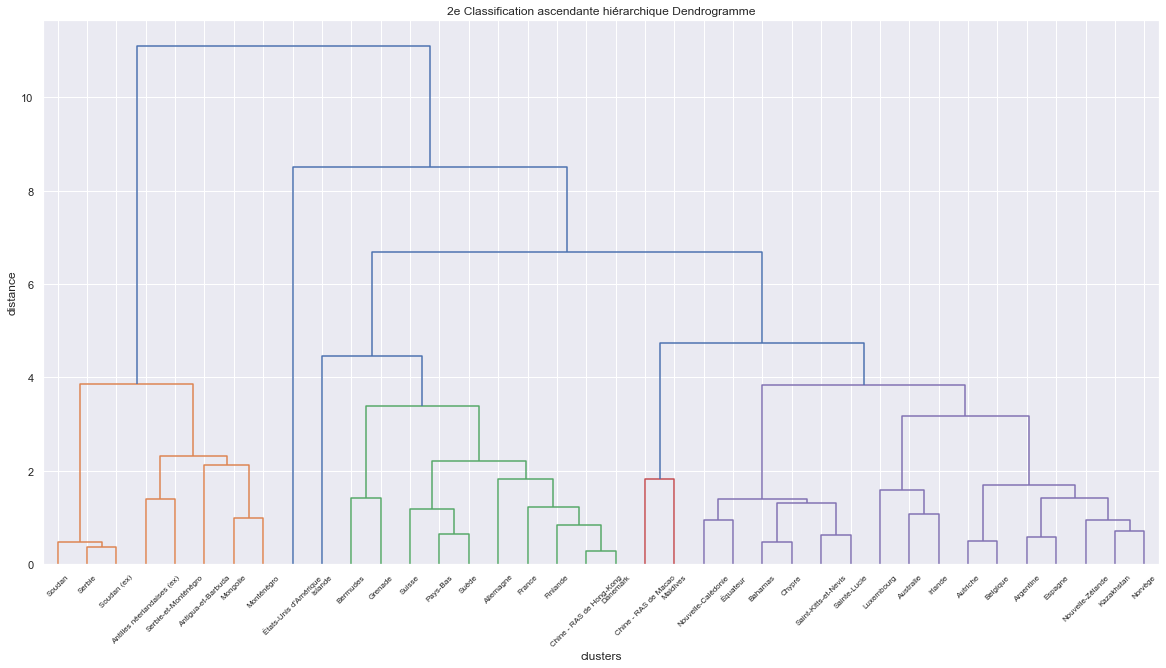

In [59]:
# préparation des données pour le clustering
cluster_pib.set_index('Zone', inplace=True)
Y = cluster_pib.values

# conversion des nombres entiers en nombres décimaux (float) 
# : necessaire pour le StandardScaler
Y = Y.astype(np.float64)
names = cluster_pib.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(Y)
Y_scaled = std_scale.transform(Y)

# Clustering hiérarchique
Z2 = linkage(Y_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(20,10))
plt.title('2e Classification ascendante hiérarchique Dendrogramme')
plt.ylabel('distance')
plt.xlabel('clusters')
# color_threshold permet de couper le dendrogramme en groupe à partir 
# de la distance sélectionnée
sch.dendrogram(Z2, labels = names, no_labels=False, color_threshold = 4)
plt.show()

In [60]:
#découpage à la hauteur t = 4, on aura 6 groupes
groupes2= fcluster(Z2,t=4,criterion='distance')
groupes2

array([2, 1, 1, 5, 5, 5, 5, 5, 2, 2, 4, 5, 2, 5, 2, 2, 2, 5, 3, 5, 5, 4,
       1, 1, 5, 5, 5, 2, 5, 5, 1, 1, 1, 1, 2, 2, 5, 6], dtype=int32)

In [61]:
cluster_pib.index
cluster_pib.values
groupes2 = pd.DataFrame(groupes2, columns=['sous_groupe'], index=cluster_pib.index)
groupes2

,sous_groupe
Zone,
Allemagne,2
Antigua-et-Barbuda,1
Antilles néerlandaises (ex),1
Argentine,5
Australie,5
Autriche,5
Bahamas,5
Belgique,5
Bermudes,2


In [62]:
clusters2 = pd.concat([groupes2, cluster_pib], axis=1).reset_index()
clusters2 = clusters2[["Zone","sous_groupe","kcal_jr","proteine_jr","percent_pop","ratio_proteine","pib"]]
clusters2

,Zone,sous_groupe,kcal_jr,proteine_jr,percent_pop,ratio_proteine,pib
0,Allemagne,2,6744.0,86.10,-0.54000,1.82,3.732743e+12
1,Antigua-et-Barbuda,1,4439.0,54.11,15.40000,2.38,1.181448e+09
2,Antilles néerlandaises (ex),1,3503.0,44.34,22.42000,1.75,3.660820e+11
3,Argentine,5,6483.0,80.80,10.79000,1.86,6.133160e+11
4,Australie,5,6309.0,84.61,18.50000,2.05,1.543216e+12
5,Autriche,5,7116.0,92.28,4.65000,1.78,4.300687e+11
6,Bahamas,5,5684.0,73.03,17.26000,1.80,1.056840e+10
7,Belgique,5,7550.0,91.43,7.05000,1.71,5.216427e+11
8,Bermudes,2,4920.0,57.99,-2.36000,2.21,6.465756e+09
9,Chine - RAS de Hong-Kong,2,6297.0,86.89,5.41000,1.97,2.756969e+11


In [63]:
clusters2_mean = clusters2.groupby("sous_groupe").mean().reset_index()
clusters2_mean

,sous_groupe,kcal_jr,proteine_jr,percent_pop,ratio_proteine,pib
0,1,3101.000,48.405000,16.919075,1.578750,1.536002e+11
1,2,6115.200,78.846000,4.424000,2.087000,9.618210e+11
2,3,5554.000,73.830000,13.630000,3.330000,1.603352e+10
3,4,5913.500,86.410000,31.385000,1.585000,2.742369e+10
4,5,6175.875,82.903125,13.150625,1.735625,3.659780e+11
5,6,7746.000,92.620000,9.170000,1.990000,1.678485e+13


In [64]:
# Selection du cluster le plus interessant

Text(0.5, 1.0, 'sous-groupes de clusters par kcal_jr')

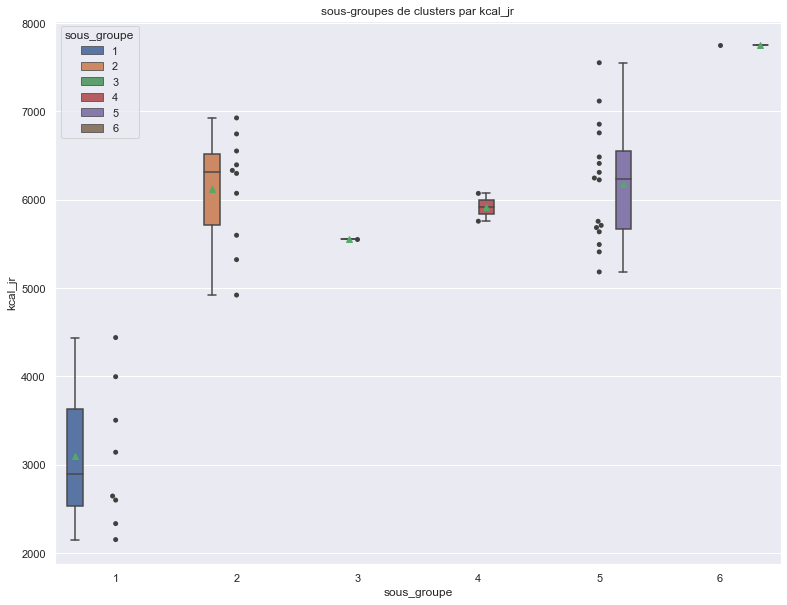

In [65]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bp1 = sns.boxplot(x='sous_groupe', y='kcal_jr', data=clusters2, showmeans=True, hue='sous_groupe').set_title("sous-groupes de clusters par kcal_jr")

# methode swarmplot nous permet de visualiser d'une meilleure façon la distribution des individus le long du boxplot
sns.swarmplot(x='sous_groupe', y='kcal_jr',  data=clusters2, color=".25")
bp1

Text(0.5, 1.0, 'sous-groupes de clusters par proteine_jr')

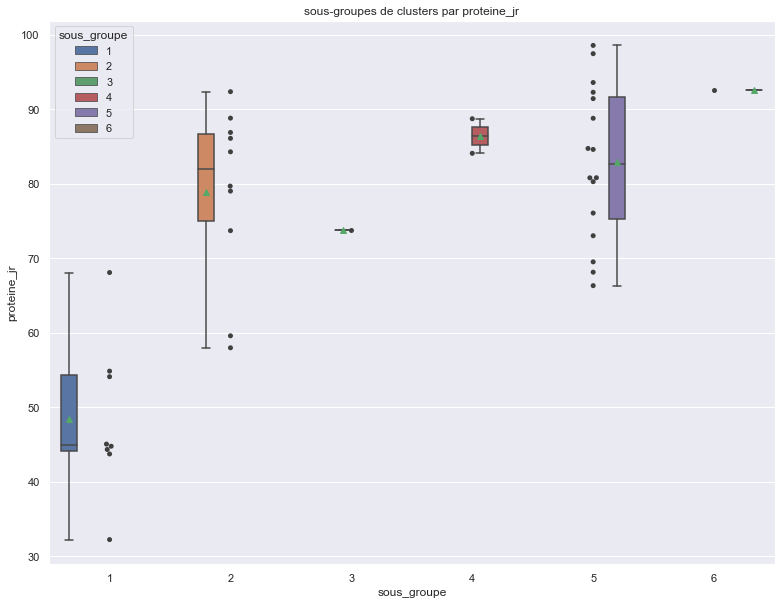

In [66]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})

bp2 = sns.boxplot(x='sous_groupe', y='proteine_jr', data=clusters2, showmeans=True, hue='sous_groupe').set_title("sous-groupes de clusters par proteine_jr")
sns.swarmplot(x='sous_groupe', y='proteine_jr',  data=clusters2, color=".25")
bp2

Text(0.5, 1.0, 'sous-groupes de clusters par ratio_proteine')

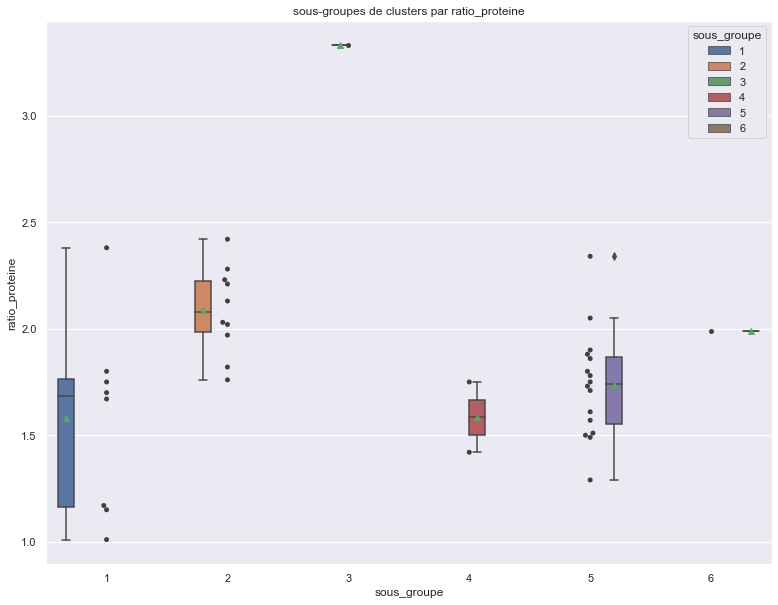

In [67]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})

bp3 = sns.boxplot(x='sous_groupe', y='ratio_proteine', data=clusters2, showmeans=True, hue='sous_groupe').set_title("sous-groupes de clusters par ratio_proteine")
sns.swarmplot(x='sous_groupe', y='ratio_proteine',  data=clusters2, color=".25")
bp3
# bp3.title('ratio_proteine') titre 

Text(0.5, 1.0, 'sous-groupes de clusters par percent_pop')

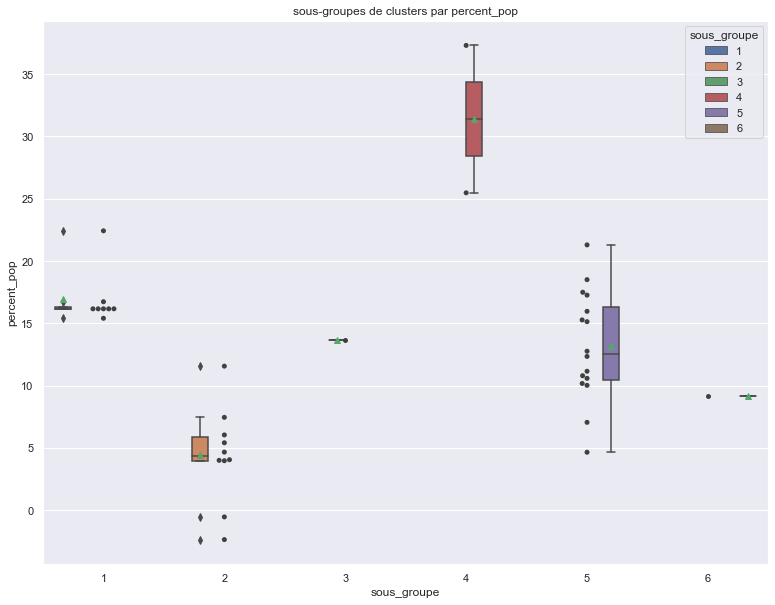

In [68]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})
bp4 = sns.boxplot(x='sous_groupe', y='percent_pop', data=clusters2, showmeans=True, hue='sous_groupe').set_title("sous-groupes de clusters par percent_pop")
sns.swarmplot(x='sous_groupe', y='percent_pop',  data=clusters2, color=".25")
bp4

Text(0.5, 1.0, 'sous-groupes de clusters par pib')

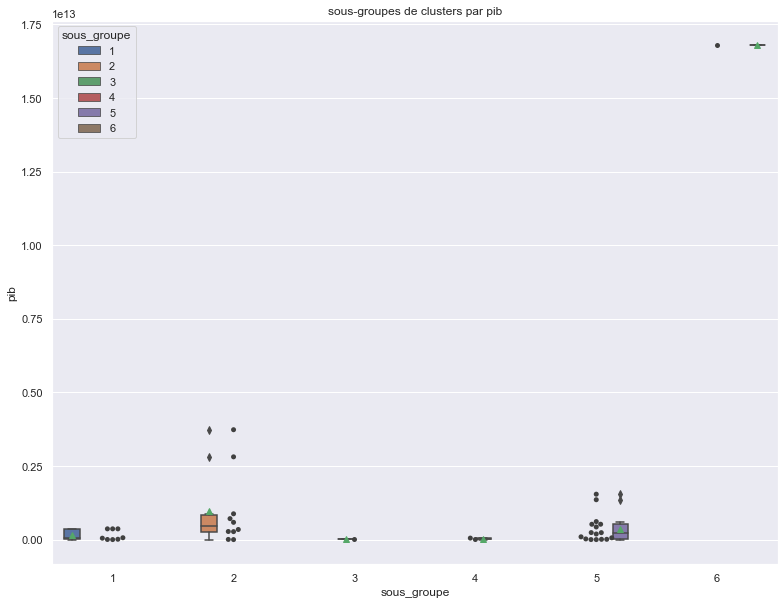

In [69]:
%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})

bp5 = sns.boxplot(x='sous_groupe', y='pib', data=clusters2, showmeans=True, hue='sous_groupe').set_title("sous-groupes de clusters par pib")
sns.swarmplot(x='sous_groupe', y='pib',  data=clusters2, color=".25")
bp5

In [70]:
centroids_cluster2 = clusters2.groupby(by='sous_groupe').mean().reset_index()
centroids_cluster2

,sous_groupe,kcal_jr,proteine_jr,percent_pop,ratio_proteine,pib
0,1,3101.000,48.405000,16.919075,1.578750,1.536002e+11
1,2,6115.200,78.846000,4.424000,2.087000,9.618210e+11
2,3,5554.000,73.830000,13.630000,3.330000,1.603352e+10
3,4,5913.500,86.410000,31.385000,1.585000,2.742369e+10
4,5,6175.875,82.903125,13.150625,1.735625,3.659780e+11
5,6,7746.000,92.620000,9.170000,1.990000,1.678485e+13


In [71]:
# choix du sous-groupe de clusters2
#Au finish, nous avons choisi les sous-groupes 2 et 6 car possédant les meilleures proportions en terme de ratio et de pib .


In [72]:
# Choix du sous-groupe de clusters2
clusters2[clusters2.sous_groupe==2]

,Zone,sous_groupe,kcal_jr,proteine_jr,percent_pop,ratio_proteine,pib
0,Allemagne,2,6744.0,86.10,-0.54,1.82,3.732743e+12
8,Bermudes,2,4920.0,57.99,-2.36,2.21,6.465756e+09
9,Chine - RAS de Hong-Kong,2,6297.0,86.89,5.41,1.97,2.756969e+11
12,Danemark,2,6551.0,84.29,4.66,2.02,3.435844e+11
14,Finlande,2,5597.0,92.36,4.05,2.03,2.712853e+11
15,France,2,6331.0,88.81,6.04,2.13,2.811078e+12
16,Grenade,2,5321.0,59.60,4.00,1.76,8.425704e+08
27,Pays-Bas,2,6394.0,79.02,3.97,2.42,8.769235e+11
34,Suisse,2,6925.0,73.71,11.56,2.23,7.127481e+11
35,Suède,2,6072.0,79.69,7.45,2.28,5.868418e+11


In [74]:
clusters2[clusters2.sous_groupe==6]

,Zone,sous_groupe,kcal_jr,proteine_jr,percent_pop,ratio_proteine,pib
37,États-Unis d'Amérique,6,7746.0,92.62,9.17,1.99,1.678485e+13


# En conclusion, les sous-groupes 2 et 6 de clusters2 sont les plus intéressants pour notre insertion dans le marché du poulet du fait 
# de leurs importantes proportions en termes de nutrition mais aussi de leur PIB